# Project setup

Import necessary libraries

In [1]:
# System
import os
import shutil
import glob

# Image handling
from PIL import Image, ImageOps

# Numerical
import numpy as np
import pandas as pd
import random

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# CNN
from keras.utils import to_categorical, set_random_seed
from keras.models import Sequential, load_model, Model
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

# Tuning
import keras_tuner as kt

# Machine Learning
from sklearn.calibration import LabelEncoder
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score

/home/miikey_lol/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
2024-01-22 05:05:40.204538: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-22 05:05:40.204581: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-22 05:05:40.205252: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already be

In [2]:
SEED = 42
random.seed(SEED)
set_random_seed(SEED)
np.random.seed(SEED)

First we establish the directory to where our data is stored, and where we ultimately want to store our cleaned, preprocessed data.

In [111]:
INIT_DIR = 'chinese-handwriting-recognition-hsk-1/chinese-handwriting/'

INIT_TRAIN_DIR = os.path.join(INIT_DIR, 'CASIA-HWDB_Train/Train/')
INIT_TEST_DIR = os.path.join(INIT_DIR, 'CASIA-HWDB_Test/Test/')

DIR = 'data/'
PLOT_DIR = 'report/img/'

# Data investigation

First lets have a look at how many data classes we have in the dataset. The dataset has been split into test and train already so lets check how many classes we have in each.

In [4]:
image_classes = os.listdir(INIT_TRAIN_DIR)

if image_classes == os.listdir(INIT_TEST_DIR):
    print('The same classes are in each folder')
else:
    print('The two folders contain different classes')

The same classes are in each folder


In [5]:
# # image_classes = ['零', '一', '二']
# # image_classes = ['零', '一', '二', '三', '四', '五', '六', '七', '八', '九', '十']
# # image_classes = image_classes_train[:20]
# image_classes = random.sample(image_classes, 50)
# # image_classes = image_classes_train

Next, lets combine the the train and test data into one directory for simplicity.

We start by creating a new directory for our preprocessed data.

In [6]:
# Remove old data
if os.path.exists(DIR):
    shutil.rmtree(DIR)
    
#Create the new directory
os.mkdir(DIR)
for image_class in image_classes:
    path = os.path.join(DIR, image_class)
    os.makedirs(path)

Now let's combine the train and test data into one directory. This is specified by the `DIR` variable.

In [7]:
def combineDirectories():
    for image_class in image_classes:
        images = []

        # Fetch images from train dir
        train_path = os.path.join(INIT_TRAIN_DIR, image_class)
        images += [os.path.join(train_path, file) for file in os.listdir(train_path)]

        # Fetch images from test dir
        test_path = os.path.join(INIT_TEST_DIR, image_class)
        images += [os.path.join(test_path, file) for file in os.listdir(test_path)]

        # Iterate over the splits and images and copy them to the data directory
        for i, image in enumerate(images):
            new_filename = f"{i+1}.png"
            destination_path = os.path.join(DIR, image_class, new_filename)
            shutil.copy(image, destination_path)
            
combineDirectories()

# Data Pre-processing

First lets iterate through all the images and and confirm they are all `.png` and black & white 

In [8]:
def checkGrayscale():
    # Loop through each subdirectory and file in the directory
    for subdir, dirs, images in os.walk(DIR):
        for image in images:
            if image.lower().endswith('.png'):
                file_path = os.path.join(subdir, image)

                with Image.open(file_path) as img:
                    if img.mode != 'L':
                        print(f"{file_path} is not grayscale.")
            else:
                print("Not a png file: ")
checkGrayscale()

Next let's iterate through all the images and check if any have an aspect ratio that is not 1:1.

In [9]:
def checkAspectRatios():
    image_sizes = []

    # Iterate through all the images and check if any do not have a 1:1 aspect ratio
    for subdir, dirs, images in os.walk(DIR):
        for image in images:
            file_path = os.path.join(subdir, image)
            with Image.open(file_path) as img:
                image_sizes.append(img.size[0])

                if img.size[0] != img.size[1]:
                    print(file_path, img.size)
                    
    return image_sizes
                    
image_sizes = checkAspectRatios()

Since all the images are square, this makes it easier to investigate their image sizes.

Smallest dimension: 3


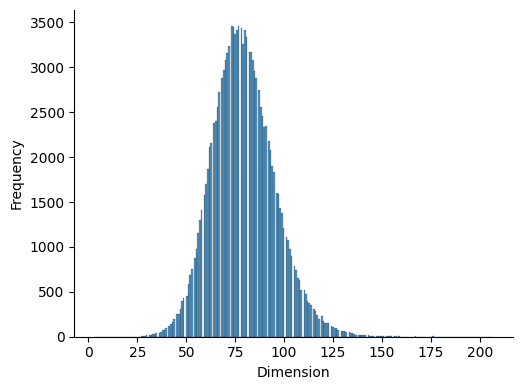

In [252]:
print(f"Smallest dimension: {min(image_sizes)}")

# Plotting
sns.displot(image_sizes, height=4, aspect=4/3)
plt.xlabel('Dimension')
plt.ylabel('Frequency')
plt.tight_layout()
plt.savefig(f"{PLOT_DIR}image_dimension_distribution.png", dpi=1000)
plt.show()

As you can see from the graph, the images are not all the same size. This will cause issues when we try to train the model, so we need to resize all the images to the same size. Additionally one of the images is only 3x3 which is way too small to be useful, so we will enforce a minimum image size.

In [11]:
MIN_IMAGE_SIZE = 20
IMAGE_SIZE = 48

def resizeImages():
    # Iterate through all the images and resize to a fixed size
    for subdir, dirs, images in os.walk(DIR):
        for image in images:
            file_path = os.path.join(subdir, image)
            with Image.open(file_path) as img:
                current_size = img.size[0]
                if current_size < MIN_IMAGE_SIZE:
                    os.remove(file_path)
                    continue
                
                if current_size != IMAGE_SIZE:
                    img = img.resize((IMAGE_SIZE, IMAGE_SIZE), Image.Resampling.LANCZOS)
                
                img = ImageOps.invert(img)
                img.save(file_path)
                
resizeImages()

Now lets check how many images we have in each class and see how balanced the classes are.

            Count
count  178.000000
mean   741.269663
std      3.031898
min    721.000000
5%     737.000000
25%    740.000000
50%    741.000000
75%    743.000000
95%    746.000000
max    748.000000


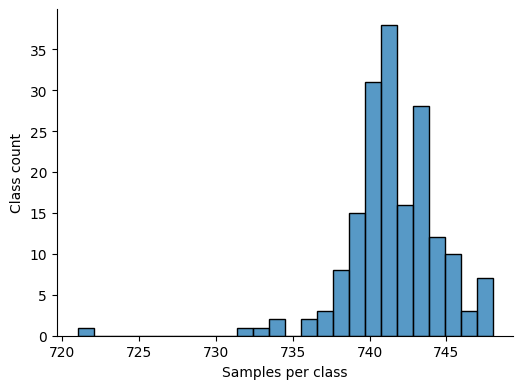

In [255]:
def get_class_counts():
    class_counts = {}
    
    for subdir in glob.glob(os.path.join(DIR, '*')):
        file_count = len(glob.glob(os.path.join(subdir, '*')))
        class_counts[subdir.split('/')[-1]] = file_count

    return pd.DataFrame.from_dict(class_counts, orient='index', columns=['Count'])

df_class_counts = get_class_counts() 

sns.displot(list(df_class_counts['Count']), height=4, aspect=4/3)
plt.xlabel('Samples per class')
plt.ylabel('Class count')
plt.tight_layout()


print(df_class_counts.describe([0.05, 0.25, 0.75, 0.95]))
plt.savefig(f"{PLOT_DIR}class_imbalance.svg")
plt.show()

From this we can see that the classes are fairly balanced, let's quickly have a look at the slight imbalance in the classes.
We can arbitrarily choose a balance metric such as outside the range of 2 standard deviations from the mean.

In [13]:
df_class_counts = get_class_counts() 

mean = df_class_counts['Count'].mean()
std = df_class_counts['Count'].std()
threshold = 2 * std

outlier_counts = df_class_counts[np.abs(df_class_counts['Count'] - mean) > threshold]
print(outlier_counts)

   Count
月    748
零    732
四    734
样    721
老    734
六    733


As we can see, the imbalance is minimal. Because of this, we will not be using any class balancing techniques.

Let's have a look some examples of the images in the dataset.

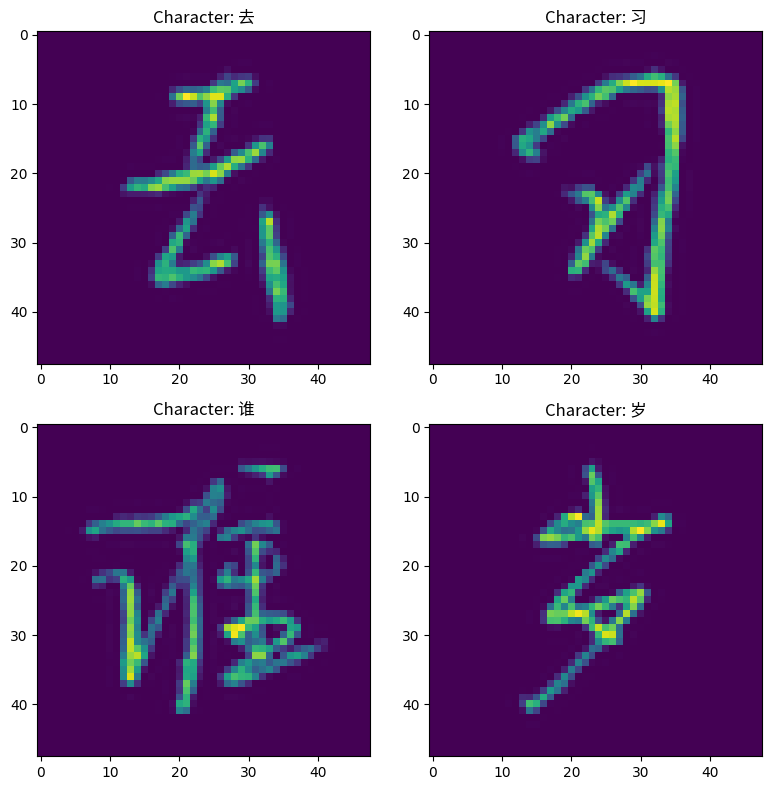

In [234]:
# Get list of all .png images in the directory and its subdirectories
images = glob.glob(os.path.join(DIR, '**', '*.png'), recursive=True)

# Randomly select num_images images
random_images = random.sample(images, 4)

fig, axs = plt.subplots(2, 2, figsize=(8, 8))

# Set the font for the plot
import matplotlib.font_manager as fm
font_path = 'NotoSansCJKsc-Regular.otf'
prop = fm.FontProperties(fname=font_path)

for i in range(2):
    for j in range(2):
        img_path = random_images[2 * i + j]
        img = Image.open(img_path)
        axs[i][j].imshow(img)
        axs[i][j].set_title(f"Character: {img_path.split('/')[1]}", fontproperties=prop,fontsize = 12)
        
plt.tight_layout()
fig.savefig(f"{PLOT_DIR}example_images.png", dpi=1000)
plt.show()

# NumPy Array Conversion

Now we can convert all the images into one single numpy array with the corresponding labels for each image.

In [15]:
def get_numpy_data(classes):
    images = []
    labels = []
    for image_class in classes:
        path = os.path.join(DIR, image_class)
        for image in os.listdir(path):
            image_path = os.path.join(path, image)

            img = Image.open(image_path)
            img_array = np.array(img)

            images.append(img_array)
            labels.append(image_class)
            
    return np.array(images), np.array(labels)

Now we can convert the python lists into numpy arrays.

In [16]:
# random_image_classes = random.sample(image_classes, 50)

images, labels = get_numpy_data(image_classes)

And finally we can save the numpy arrays to the root directory.

In [17]:
np.save('images.npy', images)
np.save('labels.npy', labels)

## Split the samples into train and test sets and one-hot encode the labels

In [18]:
images = np.load('images.npy').astype("float32") / 255
labels = np.load('labels.npy')

X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=SEED, stratify=labels)

encoder = LabelEncoder().fit(np.concatenate((y_train, y_test)))

def encode_labels(encoder: LabelEncoder, labels):
    integer_labels = encoder.transform(labels)
    ohe_labels = to_categorical(integer_labels)
    return integer_labels, ohe_labels

y_train_int, y_train_ohe = encode_labels(encoder, y_train)
y_test_int, y_test_ohe = encode_labels(encoder, y_test)

NUM_CLASSES = y_train_ohe.shape[1]

## General information about input tensors

In [19]:
print(X_train.shape)
print(X_test.shape)

print(y_train_int.shape)
print(y_test_int.shape)

print(y_train_ohe.shape)
print(y_test_ohe.shape)

print(y_train.shape)
print(y_test.shape)

(105556, 48, 48)
(26390, 48, 48)
(105556,)
(26390,)
(105556, 178)
(26390, 178)
(105556,)
(26390,)


# Define the model

In [20]:
def getCNNModel(hp):
    model = Sequential([
        Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 1)),
        
        Conv2D(hp.Int('conv_1_filters', min_value=8, max_value=32, step=8), kernel_size=3, activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        Dropout(hp.Float('dropout_1', min_value=0.0, max_value=0.5, step=0.1)),
        
        Conv2D(hp.Int('conv_2_filters', min_value=16, max_value=64, step=16), kernel_size=3, activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        Dropout(hp.Float('dropout_2', min_value=0.0, max_value=0.5, step=0.1)),
        
        Conv2D(hp.Int('conv_3_filters', min_value=32, max_value=128, step=32), kernel_size=2, activation='relu'),
        MaxPooling2D(2, 2),
        Dropout(hp.Float('dropout_3', min_value=0.0, max_value=0.5, step=0.1)),
        
        Flatten(),
        Dense(units=hp.Int('dense_units', min_value=128, max_value=1024, step=128), activation='relu'),
        Dropout(hp.Float('dropout_4', min_value=0.0, max_value=0.7, step=0.1)),
        Dense(units=NUM_CLASSES, activation='softmax')
    ])

    # Compile the model
    model.compile(
        optimizer=Adam(
            hp.Choice('learning_rate', values=[1e-2, 5e-3, 1e-3, 5e-4, 1e-4])),
        loss='categorical_crossentropy',
        metrics=['accuracy'])

    return model

# Define the hyperparameter tuner

In [21]:
# from keras.callbacks import LearningRateScheduler
from keras.callbacks import ModelCheckpoint

tuner = kt.Hyperband(
    getCNNModel,
    objective='val_accuracy',
    max_epochs=15,
    directory='hyperband',
    project_name='cnn_tuning20')

# annealer = LearningRateScheduler(
#     lambda x: 1e-3 * 0.99 ** (2 * x))
stop_early = EarlyStopping(
    monitor='loss',
    patience=5)
checkpoint = ModelCheckpoint(
    'best_model.h5',
    monitor='val_accuracy',
    verbose=0,
    save_best_only=True)

tuner.search(
    X_train, y_train_ohe,
    validation_split=0.2,
    callbacks=[stop_early, checkpoint],
    epochs=30, batch_size=128)

Reloading Tuner from hyperband/cnn_tuning20/tuner0.json


## Output the optimal hyperparameters

In [229]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best hyperparameters: {best_hps.values}")

Best hyperparameters: {'conv_1_filters': 16, 'dropout_1': 0.1, 'conv_2_filters': 32, 'dropout_2': 0.0, 'dropout_3': 0.2, 'dense_units': 640, 'dropout_4': 0.30000000000000004, 'learning_rate': 0.001, 'tuner/epochs': 15, 'tuner/initial_epoch': 5, 'tuner/bracket': 1, 'tuner/round': 1, 'tuner/trial_id': '0021', 'conv_3_filters': 32}


## Cross validate the optimal hyperparameters

In [232]:
k = 5
kfold = KFold(n_splits=k, shuffle=True, random_state=SEED)
fold_history = []

for i, (train_idxs, val_idxs) in enumerate(kfold.split(X_train, y_train_ohe)):
    print(f"Fold {i + 1}/{k}")
    
    model = getCNNModel(best_hps)
    
    history = model.fit(
        X_train[train_idxs],
        y_train_ohe[train_idxs],
        validation_data=(X_train[val_idxs], y_train_ohe[val_idxs]),
        epochs=30,
        batch_size=64
    )
    val_acc_per_epoch = history.history['val_accuracy']
    best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
    print(f'Best epoch: {best_epoch}, Val_accuracy: {max(val_acc_per_epoch)}')
    fold_history.append(history)

Fold 1/5
Epoch 1/30
1320/1320 [==============================] - 27s 20ms/step - loss: 1.7740 - accuracy: 0.5657 - val_loss: 0.6224 - val_accuracy: 0.8249
Epoch 2/30
1320/1320 [==============================] - 25s 19ms/step - loss: 0.6985 - accuracy: 0.8001 - val_loss: 0.4090 - val_accuracy: 0.8831
Epoch 3/30
1320/1320 [==============================] - 25s 19ms/step - loss: 0.5376 - accuracy: 0.8444 - val_loss: 0.3799 - val_accuracy: 0.8908
Epoch 4/30
1320/1320 [==============================] - 24s 18ms/step - loss: 0.4566 - accuracy: 0.8643 - val_loss: 0.3276 - val_accuracy: 0.9057
Epoch 5/30
1320/1320 [==============================] - 24s 18ms/step - loss: 0.4092 - accuracy: 0.8771 - val_loss: 0.3101 - val_accuracy: 0.9092
Epoch 6/30
1320/1320 [==============================] - 24s 18ms/step - loss: 0.3630 - accuracy: 0.8905 - val_loss: 0.2801 - val_accuracy: 0.9188
Epoch 7/30
1320/1320 [==============================] - 24s 18ms/step - loss: 0.3301 - accuracy: 0.8991 - val_loss:

In [ ]:
plt.figure(figsize=(6,4))

df = pd.DataFrame(fold_history[0].history)

for i, history in enumerate(fold_history[1:]):
    df = pd.concat([df, pd.DataFrame(history.history)])

df_long = df.reset_index().melt(id_vars='index', value_vars=['accuracy', 'val_accuracy'])
df_long.rename(columns={'index': 'Epoch', 'variable': 'Metric', 'value': 'Value'}, inplace=True)

df_long = df_long.replace({'val_accuracy': 'Validation', 'accuracy': 'Training'})

df_long['Epoch'] = df_long['Epoch'] + 1

sns.lineplot(data=df_long, x='Epoch', y='Value', hue='Metric', ci='sd')
plt.xlabel('Epoch')
plt.legend()
plt.ylabel('Accuracy')

plt.savefig(f"{PLOT_DIR}train_val_accuracy_cnn.png", dpi=2000)
plt.show()

In [ ]:
plt.figure(figsize=(6,4))

df = pd.DataFrame(fold_history[0].history)

for i, history in enumerate(fold_history[1:]):
    df = pd.concat([df, pd.DataFrame(history.history)])

df_long = df.reset_index().melt(id_vars='index', value_vars=['loss', 'val_loss'])
df_long.rename(columns={'index': 'Epoch', 'variable': 'Metric', 'value': 'Value'}, inplace=True)

df_long = df_long.replace({'val_loss': 'Validation', 'loss': 'Training'})

df_long['Epoch'] = df_long['Epoch'] + 1

sns.lineplot(data=df_long, x='Epoch', y='Value', hue='Metric', ci='sd')
plt.xlabel('Epoch')
plt.legend()
plt.ylabel('Loss')

plt.savefig(f"{PLOT_DIR}train_val_accuracy_cnn.png", dpi=2000)
plt.show()

<Figure size 600x400 with 0 Axes>

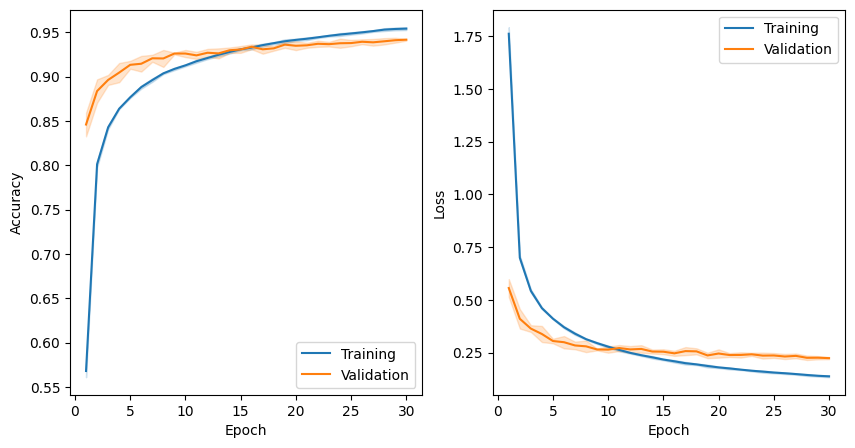

In [274]:
df = pd.DataFrame(fold_history[0].history)

for i, history in enumerate(fold_history[1:]):
    df = pd.concat([df, pd.DataFrame(history.history)])

df_long = df.reset_index().melt(id_vars='index', value_vars=['accuracy', 'val_accuracy', 'loss', 'val_loss'])

df_long.rename(columns={'index': 'Epoch', 'variable': 'Metric', 'value': 'Value'}, inplace=True)
df_long['Epoch'] = df_long['Epoch'] + 1

df_accuracy = df_long[df_long['Metric'].isin(['accuracy', 'val_accuracy'])]
df_loss = df_long[df_long['Metric'].isin(['loss', 'val_loss'])]

df_accuracy = df_accuracy.replace({'val_accuracy': 'Validation', 'accuracy': 'Training'})
df_loss = df_loss.replace({'val_loss': 'Validation', 'loss': 'Training'})

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

sns.lineplot(data=df_accuracy, x='Epoch', y='Value', hue='Metric', errorbar='sd', ax=axs[0])
sns.lineplot(data=df_loss, x='Epoch', y='Value', hue='Metric', errorbar='sd', ax=axs[1])

axs[0].set_ylabel('Accuracy')
axs[1].set_ylabel('Loss')
axs[0].legend(title=None)
axs[1].legend(title=None)

plt.xlabel('Epoch')

plt.savefig(f"{PLOT_DIR}train_val_accuracy_cnn.png", dpi=2000)
plt.show()

# Perform feature extraction

In [24]:
full_model = load_model('best_model.h5')
feature_model = Model(inputs=full_model.input, outputs=full_model.layers[-4].output)

train_features = feature_model.predict(X_train)
test_features = feature_model.predict(X_test)

825/825 [==============================] - 2s 2ms/step


In [25]:
print(train_features.shape)
print(test_features.shape)

(105556, 512)
(26390, 512)


# Grid Search kNN Hyperparameters

In [30]:
param_grid = {
    'n_neighbors': [*range(1, 18, 1)],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

knn = KNeighborsClassifier()

knn_grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')
knn_grid_search.fit(train_features, y_train_int)

print("Best parameters:", knn_grid_search.best_params_)

print("Best score:", knn_grid_search.best_score_)

Best parameters: {'metric': 'euclidean', 'n_neighbors': 10, 'weights': 'distance'}
Best score: 0.8616658485294953


# Graph of kNN Accuracy and F1 Score against k

In [34]:
f1s = []
accuracys = []

for i in range(2, 50, 1):
    # Create an instance of the KNN classifier
    knn = KNeighborsClassifier(metric='euclidean', weights='distance', n_neighbors=i, n_jobs=-1)

    # Fit the classifier to the training data
    knn.fit(train_features, y_train)
    
    # Predict the labels for the test data
    knn_predictions = knn.predict(test_features)
    
    # Calculate the accuracy score
    accuracys.append(accuracy_score(y_test, knn_predictions))

    # Calculate the f1 score
    f1s.append(f1_score(y_test, knn_predictions, average='weighted'))
    
    print(f"k={i}, {accuracys[-1]}, {f1s[-1]}")

k=2, 0.8381205001894657, 0.8387240538967996
k=3, 0.8566123531640774, 0.8571649917387293
k=4, 0.8629784009094353, 0.8637039430644583
k=5, 0.8650625236832133, 0.8660843958678067
k=6, 0.8676392572944297, 0.868776534310295
k=7, 0.8676013641530883, 0.8688886930342263
k=8, 0.8683592269799166, 0.8697706986868178
k=9, 0.8678287230011368, 0.8692751101932903
k=10, 0.8674118984463812, 0.8691277203368415
k=11, 0.8670329670329671, 0.8688663766995725
k=12, 0.8676392572944297, 0.8696946890274262
k=13, 0.8661614247821144, 0.8682940756903367
k=14, 0.8669571807502842, 0.8692623831649409
k=15, 0.8663129973474801, 0.8687254537606021
k=16, 0.8654414550966275, 0.8679883199311986
k=17, 0.864304660856385, 0.8669645335413411
k=18, 0.8627889352027283, 0.8654820769398032
k=19, 0.8634710117468738, 0.8662422366975451
k=20, 0.8627131489200455, 0.8655019913357126
k=21, 0.861576354679803, 0.8644720318361776
k=22, 0.8608942781356574, 0.8637980957092172
k=23, 0.859681697612732, 0.8626917605422004
k=24, 0.85903751420992

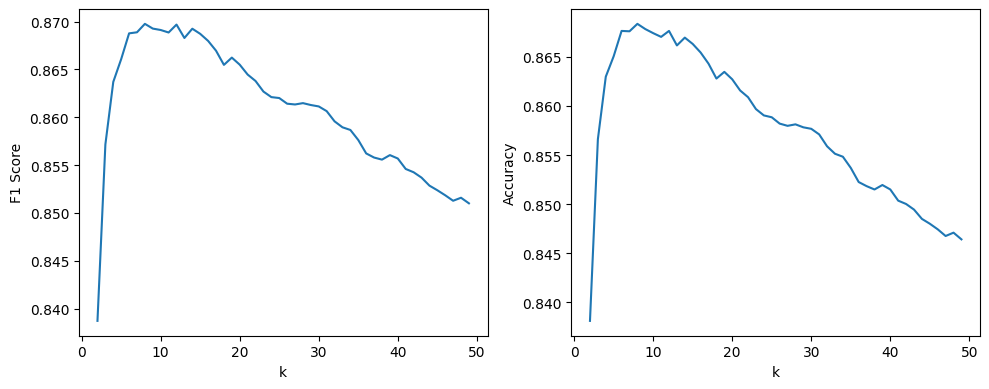

In [51]:
STEP = 1
k_values = range(2, 50, STEP)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

ax1.plot(k_values, f1s[::STEP])
ax1.set_xlabel('k')
ax1.set_ylabel('F1 Score')

ax2.plot(k_values, accuracys[::STEP])
ax2.set_xlabel('k')
ax2.set_ylabel('Accuracy')

plt.tight_layout()
plt.show()


# Grid Search Logistic Regression Hyperparameters

In [ ]:
param_grid = [
    {
        'solver': ['saga'],
        'penalty': ['elasticnet'],
        'C': [10, 5, 1, 0.5, 0.1],
        'l1_ratio': [0.25, 0.5, 0.75],
        'multi_class': ['multinomial']},
    {
        'solver': ['saga'],
        'penalty': ['l1', 'l2', 'none'],
        'C': [10, 5, 1, 0.5, 0.1],
        'multi_class': ['multinomial']},
    {
        'solver': ['sag', 'lbfgs', 'newton-cg'],
        'penalty': ['l2', 'none'],
        'C': [10, 5, 1, 0.5, 0.1],
        'multi_class': ['multinomial']}
]

logistic_regressor = LogisticRegression(
    class_weight='balanced',
    max_iter=400,
    n_jobs=-1,
    random_state=SEED)

log_grid_search = GridSearchCV(logistic_regressor, param_grid, cv=5, scoring='accuracy')
log_grid_search.fit(train_features, y_train_int)


In [53]:
print("Best parameters:", log_grid_search.best_params_)
print("Best score:", log_grid_search.best_score_)

Best parameters: {'C': 5, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'lbfgs'}
Best score: 0.9159877221569593


In [52]:
logistic_regressor = log_grid_search.best_estimator_
log_predictions = logistic_regressor.predict(test_features)
report = classification_report(y_test, encoder.inverse_transform(log_predictions), digits=4)
print(report)

              precision    recall  f1-score   support

           一     0.9673    0.9933    0.9801       149
           七     0.9122    0.9122    0.9122       148
           三     0.9658    0.9527    0.9592       148
           上     0.9533    0.9662    0.9597       148
           下     0.9231    0.9664    0.9443       149
           不     0.9517    0.9262    0.9388       149
           东     0.9065    0.8456    0.8750       149
           个     0.9595    0.9530    0.9562       149
           中     0.8954    0.9257    0.9103       148
           么     0.9161    0.9660    0.9404       147
           九     0.9320    0.9195    0.9257       149
           习     0.9400    0.9463    0.9431       149
           书     0.9338    0.9527    0.9431       148
           买     0.9178    0.9054    0.9116       148
           了     0.9119    0.9797    0.9446       148
           二     0.9363    0.9866    0.9608       149
           五     0.9348    0.8716    0.9021       148
           些     0.9600    

In [86]:
import time
from sklearn.metrics import log_loss

train_images, val_images, train_labels, val_labels = train_test_split(train_features, y_train_int, test_size=0.2, random_state=SEED, stratify=y_train_int)

k = 40
kfold = KFold(n_splits=k, shuffle=True, random_state=SEED)

knn = KNeighborsClassifier(metric='euclidean', n_neighbors=10, weights='distance')
lgr = LogisticRegression(C=5, multi_class='multinomial', penalty='l2', solver='lbfgs')

num_samples = []
knn_accuracies = []
lgr_accuracies = []
knn_losses = []
lgr_losses = []
knn_training_times = []
lgr_training_times = []
knn_inference_times = []
lgr_inference_times = []
fitted = None

# Really hacky and stupid way to train the models on increasingly more portions of the dataset
for i, (useless_idxs, idxs) in enumerate(kfold.split(train_images, train_labels)):
    print(f"Portion {i + 1}/{k}")
    
    if not fitted:
        fitted = train_images[idxs], train_labels[idxs]
    else:
        fitted = np.concatenate((fitted[0], train_images[idxs])), np.concatenate((fitted[1], train_labels[idxs]))
    
    num_samples.append(len(fitted[0]))
    
    # Get the training times
    start_time = time.time()
    knn.fit(fitted[0], fitted[1])
    end_time = time.time()
    knn_training_times.append(end_time - start_time)
    
    start_time = time.time()
    lgr.fit(fitted[0], fitted[1])
    end_time = time.time()
    lgr_training_times.append(end_time - start_time)
    
    # Get the inference times
    start_time = time.time()
    knn.predict(val_images)
    end_time = time.time()
    knn_inference_times.append(end_time - start_time)
    
    start_time = time.time()
    lgr.predict(val_images)
    end_time = time.time()
    lgr_inference_times.append(end_time - start_time)
    
    
    # Get the cross-entropy loss for each model
    knn_probs = knn.predict_proba(val_images)
    log_reg_probs = lgr.predict_proba(val_images)
    knn_loss = log_loss(val_labels, knn_probs)
    lgr_loss = log_loss(val_labels, log_reg_probs)
    knn_losses.append(knn_loss)
    lgr_losses.append(lgr_loss)
    
    # Get the accuracies
    knn_accuracy = knn.score(val_images, val_labels)
    lgr_accuracy = lgr.score(val_images, val_labels)
    
    knn_accuracies.append(knn_accuracy)
    lgr_accuracies.append(lgr_accuracy)
    
    print("num_samples:", num_samples)
    print("knn_accuracies:", knn_accuracies)
    print("lgr_accuracies:", lgr_accuracies)
    print("knn_losses:", knn_losses)
    print("lgr_losses:", lgr_losses)
    print("knn_training_times:", knn_training_times)
    print("lgr_training_times:", lgr_training_times)
    print("knn_inference_times:", knn_inference_times)
    print("lgr_inference_times:", lgr_inference_times)


Portion 1/40


/home/miikey_lol/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


num_samples: [2112]
knn_accuracies: [0.5712391057218643]
lgr_accuracies: [0.7366426676771505]
knn_losses: [6.29129793386976]
lgr_losses: [1.3684780554067046]
knn_training_times: [0.0006830692291259766]
lgr_training_times: [2.3986215591430664]
knn_inference_times: [0.3621714115142822]
lgr_inference_times: [0.05351686477661133]
Portion 2/40


/home/miikey_lol/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


num_samples: [2112, 4224]
knn_accuracies: [0.5712391057218643, 0.6695244410761653]
lgr_accuracies: [0.7366426676771505, 0.8104395604395604]
knn_losses: [6.29129793386976, 4.513130257780753]
lgr_losses: [1.3684780554067046, 0.9271987982518046]
knn_training_times: [0.0006830692291259766, 0.0011737346649169922]
lgr_training_times: [2.3986215591430664, 4.427042007446289]
knn_inference_times: [0.3621714115142822, 0.5278475284576416]
lgr_inference_times: [0.05351686477661133, 0.0496220588684082]
Portion 3/40


/home/miikey_lol/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/miikey_lol/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


num_samples: [2112, 4224, 6336]
knn_accuracies: [0.5712391057218643, 0.6695244410761653, 0.7122963243652899]
lgr_accuracies: [0.7366426676771505, 0.8104395604395604, 0.8402330428192497]
knn_losses: [6.29129793386976, 4.513130257780753, 3.9331587982676846]
lgr_losses: [1.3684780554067046, 0.9271987982518046, 0.7573565550524998]
knn_training_times: [0.0006830692291259766, 0.0011737346649169922, 0.0015690326690673828]
lgr_training_times: [2.3986215591430664, 4.427042007446289, 5.8483405113220215]
knn_inference_times: [0.3621714115142822, 0.5278475284576416, 0.733877420425415]
lgr_inference_times: [0.05351686477661133, 0.0496220588684082, 0.05375385284423828]
Portion 4/40


/home/miikey_lol/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/miikey_lol/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


num_samples: [2112, 4224, 6336, 8448]
knn_accuracies: [0.5712391057218643, 0.6695244410761653, 0.7122963243652899, 0.7429897688518378]
lgr_accuracies: [0.7366426676771505, 0.8104395604395604, 0.8402330428192497, 0.8527851458885941]
knn_losses: [6.29129793386976, 4.513130257780753, 3.9331587982676846, 3.5149731302320473]
lgr_losses: [1.3684780554067046, 0.9271987982518046, 0.7573565550524998, 0.66160376527364]
knn_training_times: [0.0006830692291259766, 0.0011737346649169922, 0.0015690326690673828, 0.0019927024841308594]
lgr_training_times: [2.3986215591430664, 4.427042007446289, 5.8483405113220215, 7.475382328033447]
knn_inference_times: [0.3621714115142822, 0.5278475284576416, 0.733877420425415, 0.839763879776001]
lgr_inference_times: [0.05351686477661133, 0.0496220588684082, 0.05375385284423828, 0.05952763557434082]
Portion 5/40


/home/miikey_lol/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/miikey_lol/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


num_samples: [2112, 4224, 6336, 8448, 10559]
knn_accuracies: [0.5712391057218643, 0.6695244410761653, 0.7122963243652899, 0.7429897688518378, 0.7554945054945055]
lgr_accuracies: [0.7366426676771505, 0.8104395604395604, 0.8402330428192497, 0.8527851458885941, 0.8639636225843123]
knn_losses: [6.29129793386976, 4.513130257780753, 3.9331587982676846, 3.5149731302320473, 3.2235603659379364]
lgr_losses: [1.3684780554067046, 0.9271987982518046, 0.7573565550524998, 0.66160376527364, 0.5979237557930648]
knn_training_times: [0.0006830692291259766, 0.0011737346649169922, 0.0015690326690673828, 0.0019927024841308594, 0.0023572444915771484]
lgr_training_times: [2.3986215591430664, 4.427042007446289, 5.8483405113220215, 7.475382328033447, 9.23828935623169]
knn_inference_times: [0.3621714115142822, 0.5278475284576416, 0.733877420425415, 0.839763879776001, 0.993302583694458]
lgr_inference_times: [0.05351686477661133, 0.0496220588684082, 0.05375385284423828, 0.05952763557434082, 0.0487971305847168]
Por

/home/miikey_lol/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/miikey_lol/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


num_samples: [2112, 4224, 6336, 8448, 10559, 12670]
knn_accuracies: [0.5712391057218643, 0.6695244410761653, 0.7122963243652899, 0.7429897688518378, 0.7554945054945055, 0.7691360363774157]
lgr_accuracies: [0.7366426676771505, 0.8104395604395604, 0.8402330428192497, 0.8527851458885941, 0.8639636225843123, 0.8726316786661614]
knn_losses: [6.29129793386976, 4.513130257780753, 3.9331587982676846, 3.5149731302320473, 3.2235603659379364, 3.02503806282649]
lgr_losses: [1.3684780554067046, 0.9271987982518046, 0.7573565550524998, 0.66160376527364, 0.5979237557930648, 0.555361195668599]
knn_training_times: [0.0006830692291259766, 0.0011737346649169922, 0.0015690326690673828, 0.0019927024841308594, 0.0023572444915771484, 0.0026857852935791016]
lgr_training_times: [2.3986215591430664, 4.427042007446289, 5.8483405113220215, 7.475382328033447, 9.23828935623169, 11.888451099395752]
knn_inference_times: [0.3621714115142822, 0.5278475284576416, 0.733877420425415, 0.839763879776001, 0.993302583694458, 1

/home/miikey_lol/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/miikey_lol/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


num_samples: [2112, 4224, 6336, 8448, 10559, 12670, 14781]
knn_accuracies: [0.5712391057218643, 0.6695244410761653, 0.7122963243652899, 0.7429897688518378, 0.7554945054945055, 0.7691360363774157, 0.7787514209928003]
lgr_accuracies: [0.7366426676771505, 0.8104395604395604, 0.8402330428192497, 0.8527851458885941, 0.8639636225843123, 0.8726316786661614, 0.879784009094354]
knn_losses: [6.29129793386976, 4.513130257780753, 3.9331587982676846, 3.5149731302320473, 3.2235603659379364, 3.02503806282649, 2.8771160315283812]
lgr_losses: [1.3684780554067046, 0.9271987982518046, 0.7573565550524998, 0.66160376527364, 0.5979237557930648, 0.555361195668599, 0.521968925353168]
knn_training_times: [0.0006830692291259766, 0.0011737346649169922, 0.0015690326690673828, 0.0019927024841308594, 0.0023572444915771484, 0.0026857852935791016, 0.003070354461669922]
lgr_training_times: [2.3986215591430664, 4.427042007446289, 5.8483405113220215, 7.475382328033447, 9.23828935623169, 11.888451099395752, 11.8174238204

/home/miikey_lol/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/miikey_lol/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


num_samples: [2112, 4224, 6336, 8448, 10559, 12670, 14781, 16892]
knn_accuracies: [0.5712391057218643, 0.6695244410761653, 0.7122963243652899, 0.7429897688518378, 0.7554945054945055, 0.7691360363774157, 0.7787514209928003, 0.7877510420613869]
lgr_accuracies: [0.7366426676771505, 0.8104395604395604, 0.8402330428192497, 0.8527851458885941, 0.8639636225843123, 0.8726316786661614, 0.879784009094354, 0.884331186055324]
knn_losses: [6.29129793386976, 4.513130257780753, 3.9331587982676846, 3.5149731302320473, 3.2235603659379364, 3.02503806282649, 2.8771160315283812, 2.7684384412458245]
lgr_losses: [1.3684780554067046, 0.9271987982518046, 0.7573565550524998, 0.66160376527364, 0.5979237557930648, 0.555361195668599, 0.521968925353168, 0.4964697929778308]
knn_training_times: [0.0006830692291259766, 0.0011737346649169922, 0.0015690326690673828, 0.0019927024841308594, 0.0023572444915771484, 0.0026857852935791016, 0.003070354461669922, 0.003828287124633789]
lgr_training_times: [2.3986215591430664, 4

/home/miikey_lol/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/miikey_lol/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


num_samples: [2112, 4224, 6336, 8448, 10559, 12670, 14781, 16892, 19003]
knn_accuracies: [0.5712391057218643, 0.6695244410761653, 0.7122963243652899, 0.7429897688518378, 0.7554945054945055, 0.7691360363774157, 0.7787514209928003, 0.7877510420613869, 0.7952349374763168]
lgr_accuracies: [0.7366426676771505, 0.8104395604395604, 0.8402330428192497, 0.8527851458885941, 0.8639636225843123, 0.8726316786661614, 0.879784009094354, 0.884331186055324, 0.8880257673361122]
knn_losses: [6.29129793386976, 4.513130257780753, 3.9331587982676846, 3.5149731302320473, 3.2235603659379364, 3.02503806282649, 2.8771160315283812, 2.7684384412458245, 2.6233634277119653]
lgr_losses: [1.3684780554067046, 0.9271987982518046, 0.7573565550524998, 0.66160376527364, 0.5979237557930648, 0.555361195668599, 0.521968925353168, 0.4964697929778308, 0.47328235041606376]
knn_training_times: [0.0006830692291259766, 0.0011737346649169922, 0.0015690326690673828, 0.0019927024841308594, 0.0023572444915771484, 0.0026857852935791016

/home/miikey_lol/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/miikey_lol/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


num_samples: [2112, 4224, 6336, 8448, 10559, 12670, 14781, 16892, 19003, 21114]
knn_accuracies: [0.5712391057218643, 0.6695244410761653, 0.7122963243652899, 0.7429897688518378, 0.7554945054945055, 0.7691360363774157, 0.7787514209928003, 0.7877510420613869, 0.7952349374763168, 0.8000189465706707]
lgr_accuracies: [0.7366426676771505, 0.8104395604395604, 0.8402330428192497, 0.8527851458885941, 0.8639636225843123, 0.8726316786661614, 0.879784009094354, 0.884331186055324, 0.8880257673361122, 0.8902519893899205]
knn_losses: [6.29129793386976, 4.513130257780753, 3.9331587982676846, 3.5149731302320473, 3.2235603659379364, 3.02503806282649, 2.8771160315283812, 2.7684384412458245, 2.6233634277119653, 2.5374253122278354]
lgr_losses: [1.3684780554067046, 0.9271987982518046, 0.7573565550524998, 0.66160376527364, 0.5979237557930648, 0.555361195668599, 0.521968925353168, 0.4964697929778308, 0.47328235041606376, 0.45636431164323327]
knn_training_times: [0.0006830692291259766, 0.0011737346649169922, 0.

/home/miikey_lol/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/miikey_lol/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


num_samples: [2112, 4224, 6336, 8448, 10559, 12670, 14781, 16892, 19003, 21114, 23225]
knn_accuracies: [0.5712391057218643, 0.6695244410761653, 0.7122963243652899, 0.7429897688518378, 0.7554945054945055, 0.7691360363774157, 0.7787514209928003, 0.7877510420613869, 0.7952349374763168, 0.8000189465706707, 0.8053239863584691]
lgr_accuracies: [0.7366426676771505, 0.8104395604395604, 0.8402330428192497, 0.8527851458885941, 0.8639636225843123, 0.8726316786661614, 0.879784009094354, 0.884331186055324, 0.8880257673361122, 0.8902519893899205, 0.8940886699507389]
knn_losses: [6.29129793386976, 4.513130257780753, 3.9331587982676846, 3.5149731302320473, 3.2235603659379364, 3.02503806282649, 2.8771160315283812, 2.7684384412458245, 2.6233634277119653, 2.5374253122278354, 2.434208054932331]
lgr_losses: [1.3684780554067046, 0.9271987982518046, 0.7573565550524998, 0.66160376527364, 0.5979237557930648, 0.555361195668599, 0.521968925353168, 0.4964697929778308, 0.47328235041606376, 0.45636431164323327, 0.4

/home/miikey_lol/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/miikey_lol/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


num_samples: [2112, 4224, 6336, 8448, 10559, 12670, 14781, 16892, 19003, 21114, 23225, 25336]
knn_accuracies: [0.5712391057218643, 0.6695244410761653, 0.7122963243652899, 0.7429897688518378, 0.7554945054945055, 0.7691360363774157, 0.7787514209928003, 0.7877510420613869, 0.7952349374763168, 0.8000189465706707, 0.8053239863584691, 0.8099658961727927]
lgr_accuracies: [0.7366426676771505, 0.8104395604395604, 0.8402330428192497, 0.8527851458885941, 0.8639636225843123, 0.8726316786661614, 0.879784009094354, 0.884331186055324, 0.8880257673361122, 0.8902519893899205, 0.8940886699507389, 0.8971201212580523]
knn_losses: [6.29129793386976, 4.513130257780753, 3.9331587982676846, 3.5149731302320473, 3.2235603659379364, 3.02503806282649, 2.8771160315283812, 2.7684384412458245, 2.6233634277119653, 2.5374253122278354, 2.434208054932331, 2.3457035293112245]
lgr_losses: [1.3684780554067046, 0.9271987982518046, 0.7573565550524998, 0.66160376527364, 0.5979237557930648, 0.555361195668599, 0.521968925353168

/home/miikey_lol/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/miikey_lol/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


num_samples: [2112, 4224, 6336, 8448, 10559, 12670, 14781, 16892, 19003, 21114, 23225, 25336, 27447]
knn_accuracies: [0.5712391057218643, 0.6695244410761653, 0.7122963243652899, 0.7429897688518378, 0.7554945054945055, 0.7691360363774157, 0.7787514209928003, 0.7877510420613869, 0.7952349374763168, 0.8000189465706707, 0.8053239863584691, 0.8099658961727927, 0.8150341038272073]
lgr_accuracies: [0.7366426676771505, 0.8104395604395604, 0.8402330428192497, 0.8527851458885941, 0.8639636225843123, 0.8726316786661614, 0.879784009094354, 0.884331186055324, 0.8880257673361122, 0.8902519893899205, 0.8940886699507389, 0.8971201212580523, 0.8983042819249716]
knn_losses: [6.29129793386976, 4.513130257780753, 3.9331587982676846, 3.5149731302320473, 3.2235603659379364, 3.02503806282649, 2.8771160315283812, 2.7684384412458245, 2.6233634277119653, 2.5374253122278354, 2.434208054932331, 2.3457035293112245, 2.274770728154711]
lgr_losses: [1.3684780554067046, 0.9271987982518046, 0.7573565550524998, 0.661603

/home/miikey_lol/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/miikey_lol/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


num_samples: [2112, 4224, 6336, 8448, 10559, 12670, 14781, 16892, 19003, 21114, 23225, 25336, 27447, 29558]
knn_accuracies: [0.5712391057218643, 0.6695244410761653, 0.7122963243652899, 0.7429897688518378, 0.7554945054945055, 0.7691360363774157, 0.7787514209928003, 0.7877510420613869, 0.7952349374763168, 0.8000189465706707, 0.8053239863584691, 0.8099658961727927, 0.8150341038272073, 0.8185865858279652]
lgr_accuracies: [0.7366426676771505, 0.8104395604395604, 0.8402330428192497, 0.8527851458885941, 0.8639636225843123, 0.8726316786661614, 0.879784009094354, 0.884331186055324, 0.8880257673361122, 0.8902519893899205, 0.8940886699507389, 0.8971201212580523, 0.8983042819249716, 0.900909435392194]
knn_losses: [6.29129793386976, 4.513130257780753, 3.9331587982676846, 3.5149731302320473, 3.2235603659379364, 3.02503806282649, 2.8771160315283812, 2.7684384412458245, 2.6233634277119653, 2.5374253122278354, 2.434208054932331, 2.3457035293112245, 2.274770728154711, 2.233345197143674]
lgr_losses: [1.3

/home/miikey_lol/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/miikey_lol/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


num_samples: [2112, 4224, 6336, 8448, 10559, 12670, 14781, 16892, 19003, 21114, 23225, 25336, 27447, 29558, 31669]
knn_accuracies: [0.5712391057218643, 0.6695244410761653, 0.7122963243652899, 0.7429897688518378, 0.7554945054945055, 0.7691360363774157, 0.7787514209928003, 0.7877510420613869, 0.7952349374763168, 0.8000189465706707, 0.8053239863584691, 0.8099658961727927, 0.8150341038272073, 0.8185865858279652, 0.821949602122016]
lgr_accuracies: [0.7366426676771505, 0.8104395604395604, 0.8402330428192497, 0.8527851458885941, 0.8639636225843123, 0.8726316786661614, 0.879784009094354, 0.884331186055324, 0.8880257673361122, 0.8902519893899205, 0.8940886699507389, 0.8971201212580523, 0.8983042819249716, 0.900909435392194, 0.9029935581659719]
knn_losses: [6.29129793386976, 4.513130257780753, 3.9331587982676846, 3.5149731302320473, 3.2235603659379364, 3.02503806282649, 2.8771160315283812, 2.7684384412458245, 2.6233634277119653, 2.5374253122278354, 2.434208054932331, 2.3457035293112245, 2.274770

/home/miikey_lol/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/miikey_lol/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


num_samples: [2112, 4224, 6336, 8448, 10559, 12670, 14781, 16892, 19003, 21114, 23225, 25336, 27447, 29558, 31669, 33780]
knn_accuracies: [0.5712391057218643, 0.6695244410761653, 0.7122963243652899, 0.7429897688518378, 0.7554945054945055, 0.7691360363774157, 0.7787514209928003, 0.7877510420613869, 0.7952349374763168, 0.8000189465706707, 0.8053239863584691, 0.8099658961727927, 0.8150341038272073, 0.8185865858279652, 0.821949602122016, 0.823986358469117]
lgr_accuracies: [0.7366426676771505, 0.8104395604395604, 0.8402330428192497, 0.8527851458885941, 0.8639636225843123, 0.8726316786661614, 0.879784009094354, 0.884331186055324, 0.8880257673361122, 0.8902519893899205, 0.8940886699507389, 0.8971201212580523, 0.8983042819249716, 0.900909435392194, 0.9029935581659719, 0.9041777188328912]
knn_losses: [6.29129793386976, 4.513130257780753, 3.9331587982676846, 3.5149731302320473, 3.2235603659379364, 3.02503806282649, 2.8771160315283812, 2.7684384412458245, 2.6233634277119653, 2.5374253122278354, 2

/home/miikey_lol/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/miikey_lol/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


num_samples: [2112, 4224, 6336, 8448, 10559, 12670, 14781, 16892, 19003, 21114, 23225, 25336, 27447, 29558, 31669, 33780, 35891]
knn_accuracies: [0.5712391057218643, 0.6695244410761653, 0.7122963243652899, 0.7429897688518378, 0.7554945054945055, 0.7691360363774157, 0.7787514209928003, 0.7877510420613869, 0.7952349374763168, 0.8000189465706707, 0.8053239863584691, 0.8099658961727927, 0.8150341038272073, 0.8185865858279652, 0.821949602122016, 0.823986358469117, 0.8258336491095112]
lgr_accuracies: [0.7366426676771505, 0.8104395604395604, 0.8402330428192497, 0.8527851458885941, 0.8639636225843123, 0.8726316786661614, 0.879784009094354, 0.884331186055324, 0.8880257673361122, 0.8902519893899205, 0.8940886699507389, 0.8971201212580523, 0.8983042819249716, 0.900909435392194, 0.9029935581659719, 0.9041777188328912, 0.9058355437665783]
knn_losses: [6.29129793386976, 4.513130257780753, 3.9331587982676846, 3.5149731302320473, 3.2235603659379364, 3.02503806282649, 2.8771160315283812, 2.768438441245

/home/miikey_lol/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/miikey_lol/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
/home/miikey_lol/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


num_samples: [2112, 4224, 6336, 8448, 10559, 12670, 14781, 16892, 19003, 21114, 23225, 25336, 27447, 29558, 31669, 33780, 35891, 38002]
knn_accuracies: [0.5712391057218643, 0.6695244410761653, 0.7122963243652899, 0.7429897688518378, 0.7554945054945055, 0.7691360363774157, 0.7787514209928003, 0.7877510420613869, 0.7952349374763168, 0.8000189465706707, 0.8053239863584691, 0.8099658961727927, 0.8150341038272073, 0.8185865858279652, 0.821949602122016, 0.823986358469117, 0.8258336491095112, 0.82981242895036]
lgr_accuracies: [0.7366426676771505, 0.8104395604395604, 0.8402330428192497, 0.8527851458885941, 0.8639636225843123, 0.8726316786661614, 0.879784009094354, 0.884331186055324, 0.8880257673361122, 0.8902519893899205, 0.8940886699507389, 0.8971201212580523, 0.8983042819249716, 0.900909435392194, 0.9029935581659719, 0.9041777188328912, 0.9058355437665783, 0.9072091701402046]
knn_losses: [6.29129793386976, 4.513130257780753, 3.9331587982676846, 3.5149731302320473, 3.2235603659379364, 3.02503

/home/miikey_lol/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/miikey_lol/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
/home/miikey_lol/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


num_samples: [2112, 4224, 6336, 8448, 10559, 12670, 14781, 16892, 19003, 21114, 23225, 25336, 27447, 29558, 31669, 33780, 35891, 38002, 40113]
knn_accuracies: [0.5712391057218643, 0.6695244410761653, 0.7122963243652899, 0.7429897688518378, 0.7554945054945055, 0.7691360363774157, 0.7787514209928003, 0.7877510420613869, 0.7952349374763168, 0.8000189465706707, 0.8053239863584691, 0.8099658961727927, 0.8150341038272073, 0.8185865858279652, 0.821949602122016, 0.823986358469117, 0.8258336491095112, 0.82981242895036, 0.8321807502841986]
lgr_accuracies: [0.7366426676771505, 0.8104395604395604, 0.8402330428192497, 0.8527851458885941, 0.8639636225843123, 0.8726316786661614, 0.879784009094354, 0.884331186055324, 0.8880257673361122, 0.8902519893899205, 0.8940886699507389, 0.8971201212580523, 0.8983042819249716, 0.900909435392194, 0.9029935581659719, 0.9041777188328912, 0.9058355437665783, 0.9072091701402046, 0.9084406972338007]
knn_losses: [6.29129793386976, 4.513130257780753, 3.9331587982676846, 

/home/miikey_lol/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/miikey_lol/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
/home/miikey_lol/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


num_samples: [2112, 4224, 6336, 8448, 10559, 12670, 14781, 16892, 19003, 21114, 23225, 25336, 27447, 29558, 31669, 33780, 35891, 38002, 40113, 42224]
knn_accuracies: [0.5712391057218643, 0.6695244410761653, 0.7122963243652899, 0.7429897688518378, 0.7554945054945055, 0.7691360363774157, 0.7787514209928003, 0.7877510420613869, 0.7952349374763168, 0.8000189465706707, 0.8053239863584691, 0.8099658961727927, 0.8150341038272073, 0.8185865858279652, 0.821949602122016, 0.823986358469117, 0.8258336491095112, 0.82981242895036, 0.8321807502841986, 0.8336964759378552]
lgr_accuracies: [0.7366426676771505, 0.8104395604395604, 0.8402330428192497, 0.8527851458885941, 0.8639636225843123, 0.8726316786661614, 0.879784009094354, 0.884331186055324, 0.8880257673361122, 0.8902519893899205, 0.8940886699507389, 0.8971201212580523, 0.8983042819249716, 0.900909435392194, 0.9029935581659719, 0.9041777188328912, 0.9058355437665783, 0.9072091701402046, 0.9084406972338007, 0.910240621447518]
knn_losses: [6.291297933

/home/miikey_lol/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/miikey_lol/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
/home/miikey_lol/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


num_samples: [2112, 4224, 6336, 8448, 10559, 12670, 14781, 16892, 19003, 21114, 23225, 25336, 27447, 29558, 31669, 33780, 35891, 38002, 40113, 42224, 44335]
knn_accuracies: [0.5712391057218643, 0.6695244410761653, 0.7122963243652899, 0.7429897688518378, 0.7554945054945055, 0.7691360363774157, 0.7787514209928003, 0.7877510420613869, 0.7952349374763168, 0.8000189465706707, 0.8053239863584691, 0.8099658961727927, 0.8150341038272073, 0.8185865858279652, 0.821949602122016, 0.823986358469117, 0.8258336491095112, 0.82981242895036, 0.8321807502841986, 0.8336964759378552, 0.8357805987116332]
lgr_accuracies: [0.7366426676771505, 0.8104395604395604, 0.8402330428192497, 0.8527851458885941, 0.8639636225843123, 0.8726316786661614, 0.879784009094354, 0.884331186055324, 0.8880257673361122, 0.8902519893899205, 0.8940886699507389, 0.8971201212580523, 0.8983042819249716, 0.900909435392194, 0.9029935581659719, 0.9041777188328912, 0.9058355437665783, 0.9072091701402046, 0.9084406972338007, 0.91024062144751

/home/miikey_lol/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/miikey_lol/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
/home/miikey_lol/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


num_samples: [2112, 4224, 6336, 8448, 10559, 12670, 14781, 16892, 19003, 21114, 23225, 25336, 27447, 29558, 31669, 33780, 35891, 38002, 40113, 42224, 44335, 46446]
knn_accuracies: [0.5712391057218643, 0.6695244410761653, 0.7122963243652899, 0.7429897688518378, 0.7554945054945055, 0.7691360363774157, 0.7787514209928003, 0.7877510420613869, 0.7952349374763168, 0.8000189465706707, 0.8053239863584691, 0.8099658961727927, 0.8150341038272073, 0.8185865858279652, 0.821949602122016, 0.823986358469117, 0.8258336491095112, 0.82981242895036, 0.8321807502841986, 0.8336964759378552, 0.8357805987116332, 0.8382910193255021]
lgr_accuracies: [0.7366426676771505, 0.8104395604395604, 0.8402330428192497, 0.8527851458885941, 0.8639636225843123, 0.8726316786661614, 0.879784009094354, 0.884331186055324, 0.8880257673361122, 0.8902519893899205, 0.8940886699507389, 0.8971201212580523, 0.8983042819249716, 0.900909435392194, 0.9029935581659719, 0.9041777188328912, 0.9058355437665783, 0.9072091701402046, 0.9084406

/home/miikey_lol/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/miikey_lol/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
/home/miikey_lol/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


num_samples: [2112, 4224, 6336, 8448, 10559, 12670, 14781, 16892, 19003, 21114, 23225, 25336, 27447, 29558, 31669, 33780, 35891, 38002, 40113, 42224, 44335, 46446, 48557]
knn_accuracies: [0.5712391057218643, 0.6695244410761653, 0.7122963243652899, 0.7429897688518378, 0.7554945054945055, 0.7691360363774157, 0.7787514209928003, 0.7877510420613869, 0.7952349374763168, 0.8000189465706707, 0.8053239863584691, 0.8099658961727927, 0.8150341038272073, 0.8185865858279652, 0.821949602122016, 0.823986358469117, 0.8258336491095112, 0.82981242895036, 0.8321807502841986, 0.8336964759378552, 0.8357805987116332, 0.8382910193255021, 0.8398541114058355]
lgr_accuracies: [0.7366426676771505, 0.8104395604395604, 0.8402330428192497, 0.8527851458885941, 0.8639636225843123, 0.8726316786661614, 0.879784009094354, 0.884331186055324, 0.8880257673361122, 0.8902519893899205, 0.8940886699507389, 0.8971201212580523, 0.8983042819249716, 0.900909435392194, 0.9029935581659719, 0.9041777188328912, 0.9058355437665783, 0.

/home/miikey_lol/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/miikey_lol/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
/home/miikey_lol/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


num_samples: [2112, 4224, 6336, 8448, 10559, 12670, 14781, 16892, 19003, 21114, 23225, 25336, 27447, 29558, 31669, 33780, 35891, 38002, 40113, 42224, 44335, 46446, 48557, 50668]
knn_accuracies: [0.5712391057218643, 0.6695244410761653, 0.7122963243652899, 0.7429897688518378, 0.7554945054945055, 0.7691360363774157, 0.7787514209928003, 0.7877510420613869, 0.7952349374763168, 0.8000189465706707, 0.8053239863584691, 0.8099658961727927, 0.8150341038272073, 0.8185865858279652, 0.821949602122016, 0.823986358469117, 0.8258336491095112, 0.82981242895036, 0.8321807502841986, 0.8336964759378552, 0.8357805987116332, 0.8382910193255021, 0.8398541114058355, 0.8411803713527851]
lgr_accuracies: [0.7366426676771505, 0.8104395604395604, 0.8402330428192497, 0.8527851458885941, 0.8639636225843123, 0.8726316786661614, 0.879784009094354, 0.884331186055324, 0.8880257673361122, 0.8902519893899205, 0.8940886699507389, 0.8971201212580523, 0.8983042819249716, 0.900909435392194, 0.9029935581659719, 0.9041777188328

/home/miikey_lol/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/miikey_lol/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
/home/miikey_lol/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


num_samples: [2112, 4224, 6336, 8448, 10559, 12670, 14781, 16892, 19003, 21114, 23225, 25336, 27447, 29558, 31669, 33780, 35891, 38002, 40113, 42224, 44335, 46446, 48557, 50668, 52779]
knn_accuracies: [0.5712391057218643, 0.6695244410761653, 0.7122963243652899, 0.7429897688518378, 0.7554945054945055, 0.7691360363774157, 0.7787514209928003, 0.7877510420613869, 0.7952349374763168, 0.8000189465706707, 0.8053239863584691, 0.8099658961727927, 0.8150341038272073, 0.8185865858279652, 0.821949602122016, 0.823986358469117, 0.8258336491095112, 0.82981242895036, 0.8321807502841986, 0.8336964759378552, 0.8357805987116332, 0.8382910193255021, 0.8398541114058355, 0.8411803713527851, 0.8424118984463812]
lgr_accuracies: [0.7366426676771505, 0.8104395604395604, 0.8402330428192497, 0.8527851458885941, 0.8639636225843123, 0.8726316786661614, 0.879784009094354, 0.884331186055324, 0.8880257673361122, 0.8902519893899205, 0.8940886699507389, 0.8971201212580523, 0.8983042819249716, 0.900909435392194, 0.902993

/home/miikey_lol/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/miikey_lol/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
/home/miikey_lol/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


num_samples: [2112, 4224, 6336, 8448, 10559, 12670, 14781, 16892, 19003, 21114, 23225, 25336, 27447, 29558, 31669, 33780, 35891, 38002, 40113, 42224, 44335, 46446, 48557, 50668, 52779, 54890]
knn_accuracies: [0.5712391057218643, 0.6695244410761653, 0.7122963243652899, 0.7429897688518378, 0.7554945054945055, 0.7691360363774157, 0.7787514209928003, 0.7877510420613869, 0.7952349374763168, 0.8000189465706707, 0.8053239863584691, 0.8099658961727927, 0.8150341038272073, 0.8185865858279652, 0.821949602122016, 0.823986358469117, 0.8258336491095112, 0.82981242895036, 0.8321807502841986, 0.8336964759378552, 0.8357805987116332, 0.8382910193255021, 0.8398541114058355, 0.8411803713527851, 0.8424118984463812, 0.8434539598332702]
lgr_accuracies: [0.7366426676771505, 0.8104395604395604, 0.8402330428192497, 0.8527851458885941, 0.8639636225843123, 0.8726316786661614, 0.879784009094354, 0.884331186055324, 0.8880257673361122, 0.8902519893899205, 0.8940886699507389, 0.8971201212580523, 0.8983042819249716, 

/home/miikey_lol/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/miikey_lol/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
/home/miikey_lol/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


num_samples: [2112, 4224, 6336, 8448, 10559, 12670, 14781, 16892, 19003, 21114, 23225, 25336, 27447, 29558, 31669, 33780, 35891, 38002, 40113, 42224, 44335, 46446, 48557, 50668, 52779, 54890, 57001]
knn_accuracies: [0.5712391057218643, 0.6695244410761653, 0.7122963243652899, 0.7429897688518378, 0.7554945054945055, 0.7691360363774157, 0.7787514209928003, 0.7877510420613869, 0.7952349374763168, 0.8000189465706707, 0.8053239863584691, 0.8099658961727927, 0.8150341038272073, 0.8185865858279652, 0.821949602122016, 0.823986358469117, 0.8258336491095112, 0.82981242895036, 0.8321807502841986, 0.8336964759378552, 0.8357805987116332, 0.8382910193255021, 0.8398541114058355, 0.8411803713527851, 0.8424118984463812, 0.8434539598332702, 0.8453012504736642]
lgr_accuracies: [0.7366426676771505, 0.8104395604395604, 0.8402330428192497, 0.8527851458885941, 0.8639636225843123, 0.8726316786661614, 0.879784009094354, 0.884331186055324, 0.8880257673361122, 0.8902519893899205, 0.8940886699507389, 0.89712012125

/home/miikey_lol/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/miikey_lol/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
/home/miikey_lol/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


num_samples: [2112, 4224, 6336, 8448, 10559, 12670, 14781, 16892, 19003, 21114, 23225, 25336, 27447, 29558, 31669, 33780, 35891, 38002, 40113, 42224, 44335, 46446, 48557, 50668, 52779, 54890, 57001, 59112]
knn_accuracies: [0.5712391057218643, 0.6695244410761653, 0.7122963243652899, 0.7429897688518378, 0.7554945054945055, 0.7691360363774157, 0.7787514209928003, 0.7877510420613869, 0.7952349374763168, 0.8000189465706707, 0.8053239863584691, 0.8099658961727927, 0.8150341038272073, 0.8185865858279652, 0.821949602122016, 0.823986358469117, 0.8258336491095112, 0.82981242895036, 0.8321807502841986, 0.8336964759378552, 0.8357805987116332, 0.8382910193255021, 0.8398541114058355, 0.8411803713527851, 0.8424118984463812, 0.8434539598332702, 0.8453012504736642, 0.8460591133004927]
lgr_accuracies: [0.7366426676771505, 0.8104395604395604, 0.8402330428192497, 0.8527851458885941, 0.8639636225843123, 0.8726316786661614, 0.879784009094354, 0.884331186055324, 0.8880257673361122, 0.8902519893899205, 0.8940

/home/miikey_lol/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/miikey_lol/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
/home/miikey_lol/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


num_samples: [2112, 4224, 6336, 8448, 10559, 12670, 14781, 16892, 19003, 21114, 23225, 25336, 27447, 29558, 31669, 33780, 35891, 38002, 40113, 42224, 44335, 46446, 48557, 50668, 52779, 54890, 57001, 59112, 61223]
knn_accuracies: [0.5712391057218643, 0.6695244410761653, 0.7122963243652899, 0.7429897688518378, 0.7554945054945055, 0.7691360363774157, 0.7787514209928003, 0.7877510420613869, 0.7952349374763168, 0.8000189465706707, 0.8053239863584691, 0.8099658961727927, 0.8150341038272073, 0.8185865858279652, 0.821949602122016, 0.823986358469117, 0.8258336491095112, 0.82981242895036, 0.8321807502841986, 0.8336964759378552, 0.8357805987116332, 0.8382910193255021, 0.8398541114058355, 0.8411803713527851, 0.8424118984463812, 0.8434539598332702, 0.8453012504736642, 0.8460591133004927, 0.8466275104206139]
lgr_accuracies: [0.7366426676771505, 0.8104395604395604, 0.8402330428192497, 0.8527851458885941, 0.8639636225843123, 0.8726316786661614, 0.879784009094354, 0.884331186055324, 0.8880257673361122,

/home/miikey_lol/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/miikey_lol/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
/home/miikey_lol/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


num_samples: [2112, 4224, 6336, 8448, 10559, 12670, 14781, 16892, 19003, 21114, 23225, 25336, 27447, 29558, 31669, 33780, 35891, 38002, 40113, 42224, 44335, 46446, 48557, 50668, 52779, 54890, 57001, 59112, 61223, 63334]
knn_accuracies: [0.5712391057218643, 0.6695244410761653, 0.7122963243652899, 0.7429897688518378, 0.7554945054945055, 0.7691360363774157, 0.7787514209928003, 0.7877510420613869, 0.7952349374763168, 0.8000189465706707, 0.8053239863584691, 0.8099658961727927, 0.8150341038272073, 0.8185865858279652, 0.821949602122016, 0.823986358469117, 0.8258336491095112, 0.82981242895036, 0.8321807502841986, 0.8336964759378552, 0.8357805987116332, 0.8382910193255021, 0.8398541114058355, 0.8411803713527851, 0.8424118984463812, 0.8434539598332702, 0.8453012504736642, 0.8460591133004927, 0.8466275104206139, 0.8489010989010989]
lgr_accuracies: [0.7366426676771505, 0.8104395604395604, 0.8402330428192497, 0.8527851458885941, 0.8639636225843123, 0.8726316786661614, 0.879784009094354, 0.884331186

/home/miikey_lol/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/miikey_lol/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
/home/miikey_lol/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


num_samples: [2112, 4224, 6336, 8448, 10559, 12670, 14781, 16892, 19003, 21114, 23225, 25336, 27447, 29558, 31669, 33780, 35891, 38002, 40113, 42224, 44335, 46446, 48557, 50668, 52779, 54890, 57001, 59112, 61223, 63334, 65445]
knn_accuracies: [0.5712391057218643, 0.6695244410761653, 0.7122963243652899, 0.7429897688518378, 0.7554945054945055, 0.7691360363774157, 0.7787514209928003, 0.7877510420613869, 0.7952349374763168, 0.8000189465706707, 0.8053239863584691, 0.8099658961727927, 0.8150341038272073, 0.8185865858279652, 0.821949602122016, 0.823986358469117, 0.8258336491095112, 0.82981242895036, 0.8321807502841986, 0.8336964759378552, 0.8357805987116332, 0.8382910193255021, 0.8398541114058355, 0.8411803713527851, 0.8424118984463812, 0.8434539598332702, 0.8453012504736642, 0.8460591133004927, 0.8466275104206139, 0.8489010989010989, 0.8508431223948465]
lgr_accuracies: [0.7366426676771505, 0.8104395604395604, 0.8402330428192497, 0.8527851458885941, 0.8639636225843123, 0.8726316786661614, 0.8

/home/miikey_lol/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/miikey_lol/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
/home/miikey_lol/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


num_samples: [2112, 4224, 6336, 8448, 10559, 12670, 14781, 16892, 19003, 21114, 23225, 25336, 27447, 29558, 31669, 33780, 35891, 38002, 40113, 42224, 44335, 46446, 48557, 50668, 52779, 54890, 57001, 59112, 61223, 63334, 65445, 67556]
knn_accuracies: [0.5712391057218643, 0.6695244410761653, 0.7122963243652899, 0.7429897688518378, 0.7554945054945055, 0.7691360363774157, 0.7787514209928003, 0.7877510420613869, 0.7952349374763168, 0.8000189465706707, 0.8053239863584691, 0.8099658961727927, 0.8150341038272073, 0.8185865858279652, 0.821949602122016, 0.823986358469117, 0.8258336491095112, 0.82981242895036, 0.8321807502841986, 0.8336964759378552, 0.8357805987116332, 0.8382910193255021, 0.8398541114058355, 0.8411803713527851, 0.8424118984463812, 0.8434539598332702, 0.8453012504736642, 0.8460591133004927, 0.8466275104206139, 0.8489010989010989, 0.8508431223948465, 0.8519325502084123]
lgr_accuracies: [0.7366426676771505, 0.8104395604395604, 0.8402330428192497, 0.8527851458885941, 0.86396362258431

/home/miikey_lol/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/miikey_lol/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
/home/miikey_lol/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


num_samples: [2112, 4224, 6336, 8448, 10559, 12670, 14781, 16892, 19003, 21114, 23225, 25336, 27447, 29558, 31669, 33780, 35891, 38002, 40113, 42224, 44335, 46446, 48557, 50668, 52779, 54890, 57001, 59112, 61223, 63334, 65445, 67556, 69667]
knn_accuracies: [0.5712391057218643, 0.6695244410761653, 0.7122963243652899, 0.7429897688518378, 0.7554945054945055, 0.7691360363774157, 0.7787514209928003, 0.7877510420613869, 0.7952349374763168, 0.8000189465706707, 0.8053239863584691, 0.8099658961727927, 0.8150341038272073, 0.8185865858279652, 0.821949602122016, 0.823986358469117, 0.8258336491095112, 0.82981242895036, 0.8321807502841986, 0.8336964759378552, 0.8357805987116332, 0.8382910193255021, 0.8398541114058355, 0.8411803713527851, 0.8424118984463812, 0.8434539598332702, 0.8453012504736642, 0.8460591133004927, 0.8466275104206139, 0.8489010989010989, 0.8508431223948465, 0.8519325502084123, 0.85240621447518]
lgr_accuracies: [0.7366426676771505, 0.8104395604395604, 0.8402330428192497, 0.852785145

/home/miikey_lol/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/miikey_lol/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
/home/miikey_lol/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


num_samples: [2112, 4224, 6336, 8448, 10559, 12670, 14781, 16892, 19003, 21114, 23225, 25336, 27447, 29558, 31669, 33780, 35891, 38002, 40113, 42224, 44335, 46446, 48557, 50668, 52779, 54890, 57001, 59112, 61223, 63334, 65445, 67556, 69667, 71778]
knn_accuracies: [0.5712391057218643, 0.6695244410761653, 0.7122963243652899, 0.7429897688518378, 0.7554945054945055, 0.7691360363774157, 0.7787514209928003, 0.7877510420613869, 0.7952349374763168, 0.8000189465706707, 0.8053239863584691, 0.8099658961727927, 0.8150341038272073, 0.8185865858279652, 0.821949602122016, 0.823986358469117, 0.8258336491095112, 0.82981242895036, 0.8321807502841986, 0.8336964759378552, 0.8357805987116332, 0.8382910193255021, 0.8398541114058355, 0.8411803713527851, 0.8424118984463812, 0.8434539598332702, 0.8453012504736642, 0.8460591133004927, 0.8466275104206139, 0.8489010989010989, 0.8508431223948465, 0.8519325502084123, 0.85240621447518, 0.8542535051155741]
lgr_accuracies: [0.7366426676771505, 0.8104395604395604, 0.84

/home/miikey_lol/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/miikey_lol/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
/home/miikey_lol/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


num_samples: [2112, 4224, 6336, 8448, 10559, 12670, 14781, 16892, 19003, 21114, 23225, 25336, 27447, 29558, 31669, 33780, 35891, 38002, 40113, 42224, 44335, 46446, 48557, 50668, 52779, 54890, 57001, 59112, 61223, 63334, 65445, 67556, 69667, 71778, 73889]
knn_accuracies: [0.5712391057218643, 0.6695244410761653, 0.7122963243652899, 0.7429897688518378, 0.7554945054945055, 0.7691360363774157, 0.7787514209928003, 0.7877510420613869, 0.7952349374763168, 0.8000189465706707, 0.8053239863584691, 0.8099658961727927, 0.8150341038272073, 0.8185865858279652, 0.821949602122016, 0.823986358469117, 0.8258336491095112, 0.82981242895036, 0.8321807502841986, 0.8336964759378552, 0.8357805987116332, 0.8382910193255021, 0.8398541114058355, 0.8411803713527851, 0.8424118984463812, 0.8434539598332702, 0.8453012504736642, 0.8460591133004927, 0.8466275104206139, 0.8489010989010989, 0.8508431223948465, 0.8519325502084123, 0.85240621447518, 0.8542535051155741, 0.8562428950359985]
lgr_accuracies: [0.736642667677150

/home/miikey_lol/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/miikey_lol/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
/home/miikey_lol/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


num_samples: [2112, 4224, 6336, 8448, 10559, 12670, 14781, 16892, 19003, 21114, 23225, 25336, 27447, 29558, 31669, 33780, 35891, 38002, 40113, 42224, 44335, 46446, 48557, 50668, 52779, 54890, 57001, 59112, 61223, 63334, 65445, 67556, 69667, 71778, 73889, 76000]
knn_accuracies: [0.5712391057218643, 0.6695244410761653, 0.7122963243652899, 0.7429897688518378, 0.7554945054945055, 0.7691360363774157, 0.7787514209928003, 0.7877510420613869, 0.7952349374763168, 0.8000189465706707, 0.8053239863584691, 0.8099658961727927, 0.8150341038272073, 0.8185865858279652, 0.821949602122016, 0.823986358469117, 0.8258336491095112, 0.82981242895036, 0.8321807502841986, 0.8336964759378552, 0.8357805987116332, 0.8382910193255021, 0.8398541114058355, 0.8411803713527851, 0.8424118984463812, 0.8434539598332702, 0.8453012504736642, 0.8460591133004927, 0.8466275104206139, 0.8489010989010989, 0.8508431223948465, 0.8519325502084123, 0.85240621447518, 0.8542535051155741, 0.8562428950359985, 0.8570481242895036]
lgr_acc

/home/miikey_lol/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/miikey_lol/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
/home/miikey_lol/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


num_samples: [2112, 4224, 6336, 8448, 10559, 12670, 14781, 16892, 19003, 21114, 23225, 25336, 27447, 29558, 31669, 33780, 35891, 38002, 40113, 42224, 44335, 46446, 48557, 50668, 52779, 54890, 57001, 59112, 61223, 63334, 65445, 67556, 69667, 71778, 73889, 76000, 78111]
knn_accuracies: [0.5712391057218643, 0.6695244410761653, 0.7122963243652899, 0.7429897688518378, 0.7554945054945055, 0.7691360363774157, 0.7787514209928003, 0.7877510420613869, 0.7952349374763168, 0.8000189465706707, 0.8053239863584691, 0.8099658961727927, 0.8150341038272073, 0.8185865858279652, 0.821949602122016, 0.823986358469117, 0.8258336491095112, 0.82981242895036, 0.8321807502841986, 0.8336964759378552, 0.8357805987116332, 0.8382910193255021, 0.8398541114058355, 0.8411803713527851, 0.8424118984463812, 0.8434539598332702, 0.8453012504736642, 0.8460591133004927, 0.8466275104206139, 0.8489010989010989, 0.8508431223948465, 0.8519325502084123, 0.85240621447518, 0.8542535051155741, 0.8562428950359985, 0.8570481242895036, 

/home/miikey_lol/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/miikey_lol/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
/home/miikey_lol/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


num_samples: [2112, 4224, 6336, 8448, 10559, 12670, 14781, 16892, 19003, 21114, 23225, 25336, 27447, 29558, 31669, 33780, 35891, 38002, 40113, 42224, 44335, 46446, 48557, 50668, 52779, 54890, 57001, 59112, 61223, 63334, 65445, 67556, 69667, 71778, 73889, 76000, 78111, 80222]
knn_accuracies: [0.5712391057218643, 0.6695244410761653, 0.7122963243652899, 0.7429897688518378, 0.7554945054945055, 0.7691360363774157, 0.7787514209928003, 0.7877510420613869, 0.7952349374763168, 0.8000189465706707, 0.8053239863584691, 0.8099658961727927, 0.8150341038272073, 0.8185865858279652, 0.821949602122016, 0.823986358469117, 0.8258336491095112, 0.82981242895036, 0.8321807502841986, 0.8336964759378552, 0.8357805987116332, 0.8382910193255021, 0.8398541114058355, 0.8411803713527851, 0.8424118984463812, 0.8434539598332702, 0.8453012504736642, 0.8460591133004927, 0.8466275104206139, 0.8489010989010989, 0.8508431223948465, 0.8519325502084123, 0.85240621447518, 0.8542535051155741, 0.8562428950359985, 0.85704812428

/home/miikey_lol/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/miikey_lol/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
/home/miikey_lol/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


num_samples: [2112, 4224, 6336, 8448, 10559, 12670, 14781, 16892, 19003, 21114, 23225, 25336, 27447, 29558, 31669, 33780, 35891, 38002, 40113, 42224, 44335, 46446, 48557, 50668, 52779, 54890, 57001, 59112, 61223, 63334, 65445, 67556, 69667, 71778, 73889, 76000, 78111, 80222, 82333]
knn_accuracies: [0.5712391057218643, 0.6695244410761653, 0.7122963243652899, 0.7429897688518378, 0.7554945054945055, 0.7691360363774157, 0.7787514209928003, 0.7877510420613869, 0.7952349374763168, 0.8000189465706707, 0.8053239863584691, 0.8099658961727927, 0.8150341038272073, 0.8185865858279652, 0.821949602122016, 0.823986358469117, 0.8258336491095112, 0.82981242895036, 0.8321807502841986, 0.8336964759378552, 0.8357805987116332, 0.8382910193255021, 0.8398541114058355, 0.8411803713527851, 0.8424118984463812, 0.8434539598332702, 0.8453012504736642, 0.8460591133004927, 0.8466275104206139, 0.8489010989010989, 0.8508431223948465, 0.8519325502084123, 0.85240621447518, 0.8542535051155741, 0.8562428950359985, 0.8570

/home/miikey_lol/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/miikey_lol/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
/home/miikey_lol/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


num_samples: [2112, 4224, 6336, 8448, 10559, 12670, 14781, 16892, 19003, 21114, 23225, 25336, 27447, 29558, 31669, 33780, 35891, 38002, 40113, 42224, 44335, 46446, 48557, 50668, 52779, 54890, 57001, 59112, 61223, 63334, 65445, 67556, 69667, 71778, 73889, 76000, 78111, 80222, 82333, 84444]
knn_accuracies: [0.5712391057218643, 0.6695244410761653, 0.7122963243652899, 0.7429897688518378, 0.7554945054945055, 0.7691360363774157, 0.7787514209928003, 0.7877510420613869, 0.7952349374763168, 0.8000189465706707, 0.8053239863584691, 0.8099658961727927, 0.8150341038272073, 0.8185865858279652, 0.821949602122016, 0.823986358469117, 0.8258336491095112, 0.82981242895036, 0.8321807502841986, 0.8336964759378552, 0.8357805987116332, 0.8382910193255021, 0.8398541114058355, 0.8411803713527851, 0.8424118984463812, 0.8434539598332702, 0.8453012504736642, 0.8460591133004927, 0.8466275104206139, 0.8489010989010989, 0.8508431223948465, 0.8519325502084123, 0.85240621447518, 0.8542535051155741, 0.8562428950359985,

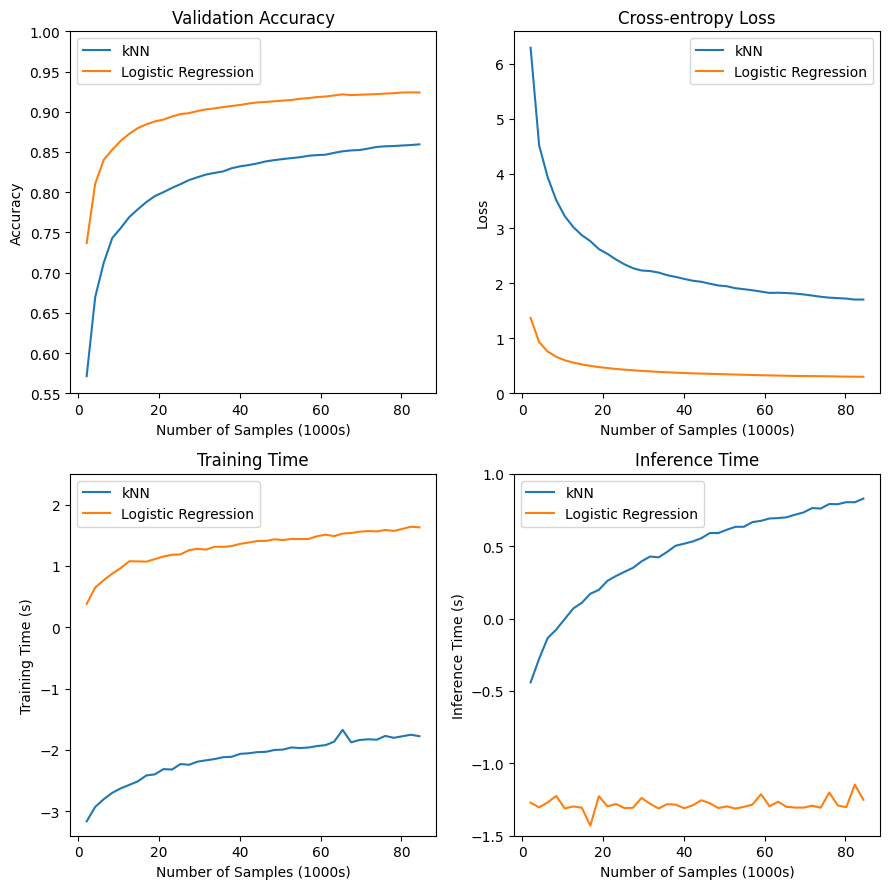

In [112]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=(9, 9))

# Plot the first value array
axs[0, 0].plot(np.array(num_samples) / 1000, knn_accuracies)
axs[0, 0].plot(np.array(num_samples) / 1000, lgr_accuracies)
axs[0, 0].set_title('Validation Accuracy')
axs[0, 0].set_xlabel('Number of Samples (1000s)')
axs[0, 0].set_ylabel('Accuracy')
axs[0, 0].set_ylim((0.55, 1))
axs[0, 0].legend(['kNN', 'Logistic Regression'], loc='upper left')

# Plot the second value array
axs[0, 1].plot(np.array(num_samples) / 1000, knn_losses)
axs[0, 1].plot(np.array(num_samples) / 1000, lgr_losses)
axs[0, 1].set_title('Cross-entropy Loss')
axs[0, 1].set_xlabel('Number of Samples (1000s)')
axs[0, 1].set_ylabel('Loss')
axs[0, 1].legend(['kNN', 'Logistic Regression'])

# Plot the third value array
axs[1, 0].plot(np.array(num_samples) / 1000, np.log10(np.array(knn_training_times)))
axs[1, 0].plot(np.array(num_samples) / 1000, np.log10(np.array(lgr_training_times)))
axs[1, 0].set_title('Training Time')
axs[1, 0].set_xlabel('Number of Samples (1000s)')
axs[1, 0].set_ylabel('Training Time (s)')
axs[1, 0].set_ylim((-3.4, 2.5))
axs[1, 0].legend(['kNN', 'Logistic Regression'])

# Plot the fourth value array
axs[1, 1].plot(np.array(num_samples) / 1000, np.log10(np.array(knn_inference_times)))
axs[1, 1].plot(np.array(num_samples) / 1000, np.log10(np.array(lgr_inference_times)))
axs[1, 1].set_title('Inference Time')
axs[1, 1].set_xlabel('Number of Samples (1000s)')
axs[1, 1].set_ylabel('Inference Time (s)')
axs[1, 1].set_ylim((-1.5, 1))
axs[1, 1].legend(['kNN', 'Logistic Regression'])

plt.tight_layout()
plt.savefig(f"{PLOT_DIR}model_eval.svg")
plt.show()

# Extra models

In [14]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, random_state=42, verbose=1, n_jobs=-1)
rf.fit(train_features, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   54.8s finished


RandomForestClassifier(n_jobs=-1, random_state=42, verbose=1)

In [15]:
rf_score = rf.score(test_features, y_test)
print(f"Random Forest Accuracy: {rf_score}")

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.4s


Random Forest Accuracy: 0.8707086017430845


[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    1.5s finished


In [8]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
# Define the parameter grid for grid search
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto']
}

# Create an instance of the SVM classifier
svm_classifier = SVC()

# Create an instance of GridSearchCV
grid_search = GridSearchCV(svm_classifier, param_grid, cv=2, verbose=1)

# Fit the classifier to the training data using grid search
grid_search.fit(train_features, y_train)

Fitting 2 folds for each of 18 candidates, totalling 36 fits


GridSearchCV(cv=2, estimator=SVC(),
             param_grid={'C': [0.1, 1, 10], 'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'rbf', 'poly']},
             verbose=1)

In [9]:
# Print the best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Best Parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best Score: 0.9421918223502217


In [56]:
from sklearn.svm import SVC
svm_classifier = SVC(C=10, gamma='scale', kernel='rbf')
svm_classifier.fit(train_features, y_train)
# Predict the labels for the test data using the best estimator
svm_predictions = svm_classifier.predict(test_features)

In [ ]:
# Calculate the accuracy score
accuracy = accuracy_score(y_test, svm_predictions)

# Calculate the f1 score
f1 = f1_score(y_test, svm_predictions, average='weighted')

# Print the accuracy and f1 score report
print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")

Accuracy: 0.951951496779083
F1 Score: 0.9520046665214275
